# GAN

In [4]:
import librosa
import io
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
path = os.getcwd()
folder_path = f'{path}/data'

In [8]:
parquet_file_path = f'../data/train-00000-of-00016-6b5481c76a3d2702.parquet'

# Load the data into a pandas DataFrame
df = pd.read_parquet(parquet_file_path, engine='pyarrow')

In [9]:
df.head()

audio  song_id  genre_id  \
0  {'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...        0         0   
1  {'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...        1         9   
2  {'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...        2         6   
3  {'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...        4         4   
4  {'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...        5        14   

               genre  
0         Electronic  
1      International  
2  Chiptune / Glitch  
3            Hip-Hop  
4            Country

In [10]:
# Reproducio audio
audio_bytes = df.loc[df['song_id'] == 0, 'audio'].values[0]['bytes']

# Reproducir el audio
Audio(audio_bytes)

In [11]:
def decode_audio(binary_data):
    # Convert bytes to file-like object
    audio_file = io.BytesIO(binary_data)
    
    # Load audio file using librosa
    y, sr = librosa.load(audio_file, sr=None)  # `sr=None` to keep the original sampling rate
    
    return y, sr

In [12]:
# Decode audio for each row in the DataFrame
df['decoded_audio'] = df['audio'].apply(lambda x: decode_audio(x['bytes']))

# Example of how to access the decoded audio and sampling rate
decoded_audio, sampling_rate = df['decoded_audio'][0]  # Accessing the first row as an example
print(f"Decoded Audio: {decoded_audio}")
print(f"Sampling Rate: {sampling_rate}")

# If you want to extract just the time series (audio data) and store it separately
df['audio_time_series'] = df['decoded_audio'].apply(lambda x: x[0])  # Extract time series data
df['sampling_rate'] = df['decoded_audio'].apply(lambda x: x[1])  # Extract sampling rate

Decoded Audio: [ 3.97139956e-07  7.30310489e-07  7.56406735e-07 ... -1.19636685e-01
 -1.16811872e-01 -1.12441733e-01]
Sampling Rate: 44100


In [13]:
df = df.drop('decoded_audio', axis=1)
df = df.drop('audio', axis=1)

Longitudes únicas de audios: [ 660719 1321967 1323119 1439471]
Longitud 660719: 2 ejemplos
Longitud 1321967: 661 ejemplos
Longitud 1323119: 531 ejemplos
Longitud 1439471: 51 ejemplos
Sampling Rate únicos de audios: [22050 44100 48000]
Longitud 22050: 2 ejemplos
Longitud 44100: 1192 ejemplos
Longitud 48000: 51 ejemplos


<function matplotlib.pyplot.show(close=None, block=None)>

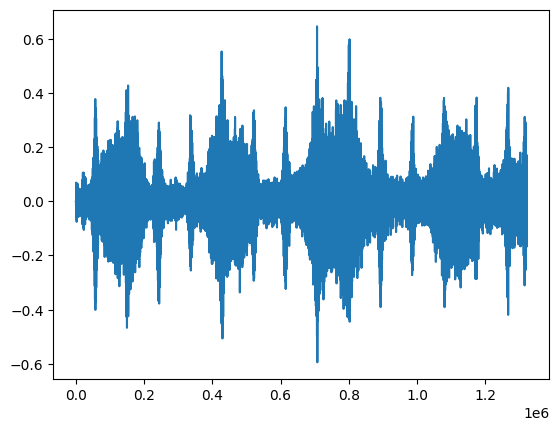

In [14]:
# Calculate the length of each audio time series
lens = [len(ts) for ts in df['audio_time_series']]
# Find unique lengths and their counts
unique_lengths, counts_len = np.unique(lens, return_counts=True)
# Print unique lengths and the number of examples for each length
print(f"Longitudes únicas de audios: {unique_lengths}")
for length, count in zip(unique_lengths, counts_len):
    print(f"Longitud {length}: {count} ejemplos")

unique_sr, counts_sr = np.unique(df.sampling_rate, return_counts=True)
# Print unique lengths and the number of examples for each sampling rate
print(f"Sampling Rate únicos de audios: {unique_sr}")
for length, count in zip(unique_sr, counts_sr):
    print(f"Longitud {length}: {count} ejemplos")


plt.plot(df.audio_time_series[10])
plt.show

# Creacion y filtros usando STFT

In [15]:
df['len_time_series'] = df['audio_time_series'].apply(len)
df

song_id  genre_id              genre  \
0           0         0         Electronic   
1           1         9      International   
2           2         6  Chiptune / Glitch   
3           4         4            Hip-Hop   
4           5        14            Country   
...       ...       ...                ...   
1240     1582         0         Electronic   
1241     1584         1               Rock   
1242     1585         6  Chiptune / Glitch   
1243     1586         0         Electronic   
1244     1587         3       Experimental   

                                      audio_time_series  sampling_rate  \
0     [3.9713996e-07, 7.303105e-07, 7.5640673e-07, 4...          44100   
1     [0.15237972, 0.13222948, 0.10627693, 0.0847923...          44100   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          44100   
3     [1.0242012e-07, -2.1464746e-08, 4.3254076e-08,...          44100   
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          44100   
...                                                 ...            ...   
1240  [-2.0301522e-06, -1.431131e-06, -8.0674374e-07...          44100   
1241  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          44100   
1242  [-2.5107475e-08, -3.072462e-08, 2.4959164e-08,...          44100   
1243  [1.033266e-09, 7.837398e-09, 2.4670022e-08, 2....          44100   
1244  [8.924363e-07, 1.0453716e-06, 7.052001e-07, 8....          44100   

      len_time_series  
0             1323119  
1             1321967  
2             1321967  
3             1323119  
4             1323119  
...               ...  
1240          1321967  
1241          1323119  
1242          1323119  
1243          1323119  
1244          1321967  

[1245 rows x 6 columns]

In [16]:
# dejamos solo el sampling rate en 44100
df = df[
    df["sampling_rate"] == 44100
].copy(deep=True)

In [17]:
MAX_LENGTH = 1321967
df = df[
    df["len_time_series"] == MAX_LENGTH
].copy(deep=True)

In [18]:
df = df[:50]

In [19]:
import librosa
import numpy as np

def audio_to_stft(audio_time_series, sr=44100, n_fft=1024, hop_length=512):
    """
    Convierte un audio time series a un STFT.

    Parámetros:
    audio_time_series (numpy array): Audio time series.
    sr (int): Frecuencia de muestreo (default=44100).
    n_fft (int): Tamaño de la ventana de Fourier (default=2048).
    hop_length (int): Longitud del salto entre ventanas (default=512).

    Retorna:
    stft (numpy array): STFT del audio.
    """
    stft = librosa.stft(audio_time_series, n_fft=n_fft, hop_length=hop_length)
    return stft

df['stft2'] = df.apply(lambda row: audio_to_stft(row['audio_time_series']), axis=1)

In [20]:
df['stft2'].iloc[0].shape

(513, 2582)

In [21]:
# Función para convertir audio_time_series a STFT
def compute_stft(audio_time_series, sampling_rate):
    # Computar STFT
    stft_result = librosa.stft(audio_time_series, n_fft=1024, hop_length=512)
    # Convertir amplitud a decibelios (dB)
    stft_db = librosa.amplitude_to_db(np.abs(stft_result), ref=np.max)
    return stft_db

# Aplicar la función a cada fila del DataFrame
df['stft'] = df.apply(lambda row: compute_stft(row['audio_time_series'], row['sampling_rate']), axis=1)

# Mostrar el DataFrame resultante
df[['song_id', 'genre', 'stft']]

song_id                genre  \
1         1        International   
2         2    Chiptune / Glitch   
5         7  Old-Time / Historic   
6         9              Hip-Hop   
8        12           Electronic   
10       14         Experimental   
11       15                Blues   
12       16              Hip-Hop   
13       18        International   
15       20              Hip-Hop   
17       22                 Punk   
18       25            Classical   
19       26        International   
22       29  Old-Time / Historic   
23       30                 Rock   
25       34                 Rock   
30       41           Electronic   
33       45              Hip-Hop   
34       46           Electronic   
35       47                 Punk   
38       52                 Punk   
39       53              Hip-Hop   
40       54        International   
42       56         Experimental   
43       58    Chiptune / Glitch   
44       59    Chiptune / Glitch   
46       62           Electronic   
47       63           Electronic   
49       68                 Punk   
53       72               Spoken   
54       73        International   
55       74                 Folk   
60       80  Old-Time / Historic   
61       81                 Punk   
63       83                 Rock   
64       84              Hip-Hop   
67       90                  Pop   
68       91                 Folk   
69       93                  Pop   
75      106        International   
76      107         Experimental   
77      108                 Punk   
79      110         Experimental   
82      115           Electronic   
83      116  Old-Time / Historic   
84      117                 Rock   
87      120  Old-Time / Historic   
88      121                  Pop   
95      129                 Rock   
97      132                 Rock   

                                                 stft  
1   [[-23.990166, -21.629631, -28.079351, -28.2595...  
2   [[-66.10268, -15.176613, -30.658028, -4.897377...  
5   [[-80.0, -80.0, -69.70636, -64.39059, -62.0941...  
6   [[-41.5159, -29.582651, -13.4792595, -40.11945...  
8   [[-22.597374, -22.59978, -23.434284, -34.92, -...  
10  [[-49.74848, -30.508219, -33.2244, -41.360092,...  
11  [[-80.0, -80.0, -80.0, -80.0, -73.488335, -78....  
12  [[-78.19925, -20.426624, -35.6457, -19.65964, ...  
13  [[-33.97943, -41.025253, -37.297527, -38.93386...  
15  [[-32.050148, -20.662586, -40.60848, -26.24223...  
17  [[-41.591393, -22.41986, -36.926365, -36.86391...  
18  [[-44.931374, -68.84477, -64.88727, -79.40172,...  
19  [[-80.0, -80.0, -34.607235, -51.159542, -44.38...  
22  [[-80.0, -80.0, -72.72375, -68.42574, -55.7149...  
23  [[-80.0, -80.0, -60.779957, -37.703415, -36.21...  
25  [[-80.0, -80.0, -43.686157, -30.87316, -28.997...  
30  [[-73.54385, -38.02877, -17.243752, -36.138245...  
33  [[-34.566868, -47.28755, -45.183723, -38.40873...  
34  [[-29.613785, -11.996113, -32.493107, -27.1167...  
35  [[-80.0, -55.86404, -37.74495, -24.284214, -13...  
38  [[-80.0, -59.228577, -41.190697, -32.672203, -...  
39  [[-38.013268, -18.231674, -23.181057, -16.9873...  
40  [[-29.97285, -11.691269, -19.685417, -30.44667...  
42  [[-51.853325, -33.060616, -33.62942, -45.07004...  
43  [[-36.641033, -26.204206, -43.837963, -25.9455...  
44  [[-51.997894, -35.273514, -21.784834, -20.1516...  
46  [[-41.141346, -25.66541, -16.047718, -14.28409...  
47  [[-75.52857, -16.27802, -26.113207, -41.91629,...  
49  [[-80.0, -80.0, -21.581772, -35.61324, -30.462...  
53  [[-80.0, -72.280304, -50.52067, -28.651333, -5...  
54  [[-80.0, -60.943554, -35.631294, -28.322027, -...  
55  [[-63.971836, -52.890404, -39.66997, -40.72481...  
60  [[-69.84035, -70.18752, -56.834167, -49.590755...  
61  [[-20.371777, -40.958916, -50.08428, -48.34315...  
63  [[-37.790783, -26.809666, -72.604126, -39.6397...  
64  [[-40.27678, -20.622974, -32.411133, -18.86910...  
67  [[-23.672749, -18.097816, -15.347225, -32.531,...  
68  [[-66.192566, -52.510445, -46.38160

In [22]:
df['stft'].iloc[0].shape

(513, 2582)

# Model

## Arquitectura

In [53]:
class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=(4, 4), stride=(1, 1), padding=0),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(True),
            
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            
            nn.ConvTranspose2d(32, output_channels, kernel_size=(8, 45), stride=(4, 20), padding=2, output_padding=(1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, x.size(1), 1, 1)
        return self.model(x)

In [54]:
from torchsummary import summary
noise_dim = 128
output_channels = 1
model = Generator(noise_dim, output_channels)
summary(model, input_size=(128, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       2,098,176
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
         LeakyReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
         LeakyReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,416
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        LeakyReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,136
      BatchNorm2d-14           [-1, 64,

In [77]:
class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=(4, 4), stride=(1, 1), padding=0),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, output_channels, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        print("Input shape: ", x.shape)
        for layer in self.model:
            x = layer(x)
            print(layer.__class__.__name__, " output shape: ", x.shape)
        return x

# Test the generator with dummy input
noise_dim = 100
output_channels = 1
generator = Generator(noise_dim, output_channels)
noise = torch.randn(1, noise_dim, 1, 1)
generated_stft = generator(noise)

Input shape:  torch.Size([1, 100, 1, 1])
ConvTranspose2d  output shape:  torch.Size([1, 1024, 4, 4])
BatchNorm2d  output shape:  torch.Size([1, 1024, 4, 4])
LeakyReLU  output shape:  torch.Size([1, 1024, 4, 4])
ConvTranspose2d  output shape:  torch.Size([1, 512, 8, 8])
BatchNorm2d  output shape:  torch.Size([1, 512, 8, 8])
LeakyReLU  output shape:  torch.Size([1, 512, 8, 8])
ConvTranspose2d  output shape:  torch.Size([1, 256, 16, 16])
BatchNorm2d  output shape:  torch.Size([1, 256, 16, 16])
LeakyReLU  output shape:  torch.Size([1, 256, 16, 16])
ConvTranspose2d  output shape:  torch.Size([1, 128, 32, 32])
BatchNorm2d  output shape:  torch.Size([1, 128, 32, 32])
LeakyReLU  output shape:  torch.Size([1, 128, 32, 32])
ConvTranspose2d  output shape:  torch.Size([1, 64, 64, 64])
BatchNorm2d  output shape:  torch.Size([1, 64, 64, 64])
LeakyReLU  output shape:  torch.Size([1, 64, 64, 64])
ConvTranspose2d  output shape:  torch.Size([1, 32, 128, 128])
BatchNorm2d  output shape:  torch.Size([1, 3

## Modelo

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [70]:
class Generator(nn.Module):
    def __init__(self, noise_dim, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=(4, 4), stride=(1, 1), padding=0),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, output_channels, kernel_size=(8, 45), stride=(4, 20), padding=2, output_padding=(1, 1)),
            # nn.ConvTranspose2d(32, output_channels, kernel_size=(8, 8), stride=(4, 12), padding=2, output_padding=(1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, x.size(1), 1, 1)
        return self.model(x)

# Definir la clase Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Parámetros de STFT
n_fft = 1024
hop_length = 512

# Parámetros del GAN
noise_dim = 128
output_channels = 1  # 1 canal porque es magnitud de STFT

# Obtener dimensiones de frecuencia y tiempo
frecuencia_dim = n_fft // 2 + 1

# Asegúrate de que las dimensiones de STFT sean correctas
frecuencia_dim = df['stft'].iloc[0].shape[0]
tiempo_dim = df['stft'].iloc[0].shape[1]
output_size = (1, frecuencia_dim, tiempo_dim)

# Inicializar modelos
generator = Generator(noise_dim, output_channels)
discriminator = Discriminator(output_channels)

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Función de pérdida
criterion = nn.BCELoss()

# Convertir STFTs a tensores y normalizar
def prepare_stft_tensor(stft):
    stft_tensor = torch.tensor(stft, dtype=torch.float32)
    stft_tensor = (stft_tensor - stft_tensor.min()) / (stft_tensor.max() - stft_tensor.min())  # Normalizar entre 0 y 1
    stft_tensor = stft_tensor.unsqueeze(0).unsqueeze(0)  # Añadir dimensiones para canales y batch
    return stft_tensor

df['stft_tensor'] = df['stft'].apply(prepare_stft_tensor)

# Crear DataLoader para entrenamiento
batch_size = 8
train_loader = torch.utils.data.DataLoader(df['stft_tensor'].tolist(), batch_size=batch_size, shuffle=True)

# Inicializa listas para almacenar las pérdidas
d_losses = []
g_losses = []

# Entrenamiento
num_epochs = 20
for epoch in range(num_epochs):
    for real_stfts in train_loader:
        real_stfts = real_stfts.squeeze(2).squeeze(2)  # Ajustar las dimensiones para que sean [batch_size, channels, height, width]
        batch_size = real_stfts.size(0)
        
        # Forward pass del discriminador con datos reales
        real_outputs = discriminator(real_stfts)
        real_labels = torch.ones_like(real_outputs)  # Ajustar el tamaño de real_labels
        d_loss_real = criterion(real_outputs, real_labels)
        
        # Generar datos falsos y forward pass del discriminador
        noise = torch.randn(batch_size, noise_dim, 1, 1)
        fake_stfts = generator(noise)
        fake_outputs = discriminator(fake_stfts.detach())
        fake_labels = torch.zeros_like(fake_outputs)  # Ajustar el tamaño de fake_labels
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        # Pérdida total y actualización del discriminador
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()
        
        # Entrenar Generador
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_stfts)
        g_loss = criterion(fake_outputs, torch.ones_like(fake_outputs))  # Usar real_labels para que el generador aprenda a generar datos reales
        g_loss.backward()
        optimizer_G.step()
        
    # Guardar las pérdidas
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

Epoch [1/20], d_loss: 0.2630460858345032, g_loss: 2.86678409576416
Epoch [2/20], d_loss: 0.07984764873981476, g_loss: 4.077694416046143
Epoch [3/20], d_loss: 0.02510981634259224, g_loss: 4.400949001312256
Epoch [4/20], d_loss: 0.016388796269893646, g_loss: 5.168985843658447
Epoch [5/20], d_loss: 0.01838730089366436, g_loss: 4.9919819831848145
Epoch [6/20], d_loss: 0.015290483832359314, g_loss: 5.132820129394531
Epoch [7/20], d_loss: 0.0063790855929255486, g_loss: 5.620926856994629
Epoch [8/20], d_loss: 0.007999598979949951, g_loss: 5.665735244750977
Epoch [9/20], d_loss: 0.00547240162268281, g_loss: 5.915515899658203
Epoch [10/20], d_loss: 0.0054781390354037285, g_loss: 6.051516056060791
Epoch [11/20], d_loss: 0.006141670048236847, g_loss: 5.922754287719727
Epoch [12/20], d_loss: 0.007113466039299965, g_loss: 6.463656425476074
Epoch [13/20], d_loss: 1.3720847368240356, g_loss: 1.382054090499878
Epoch [14/20], d_loss: 0.9771634340286255, g_loss: 1.3961669206619263
Epoch [15/20], d_loss:

In [71]:
# Generar un ejemplo a partir del ruido
noise = torch.randn(1, noise_dim, 1, 1)
generated_stft = generator(noise).detach().numpy()
generated_stft = generated_stft.squeeze()

In [72]:
generated_stft.shape

(513, 2582)

In [73]:
print(f"real_stfts.shape: {real_stfts.shape}")
print(f"real_outputs.shape: {real_outputs.shape}")
print(f"real_labels.shape: {real_labels.shape}")
print(f"fake_stfts.shape: {fake_stfts.shape}")
print(f"fake_outputs.shape: {fake_outputs.shape}")
print(f"fake_labels.shape: {fake_labels.shape}")

real_stfts.shape: torch.Size([2, 1, 513, 2582])
real_outputs.shape: torch.Size([2, 1, 13, 77])
real_labels.shape: torch.Size([2, 1, 13, 77])
fake_stfts.shape: torch.Size([2, 1, 513, 2582])
fake_outputs.shape: torch.Size([2, 1, 13, 77])
fake_labels.shape: torch.Size([2, 1, 13, 77])


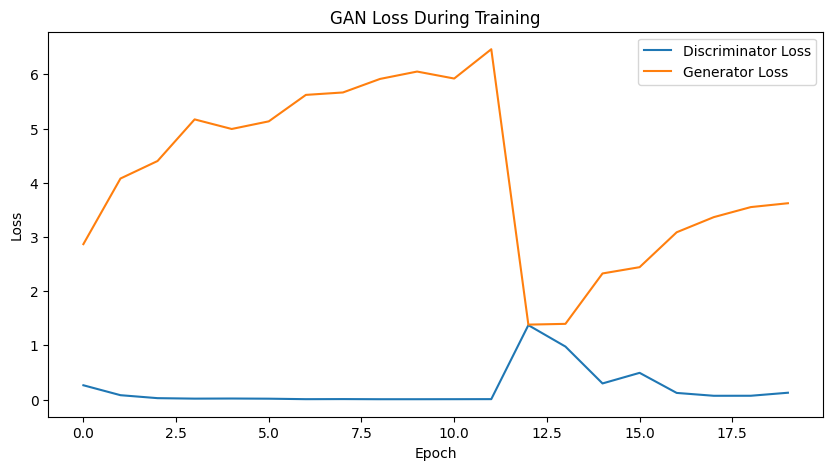

In [74]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Loss During Training')
plt.show()

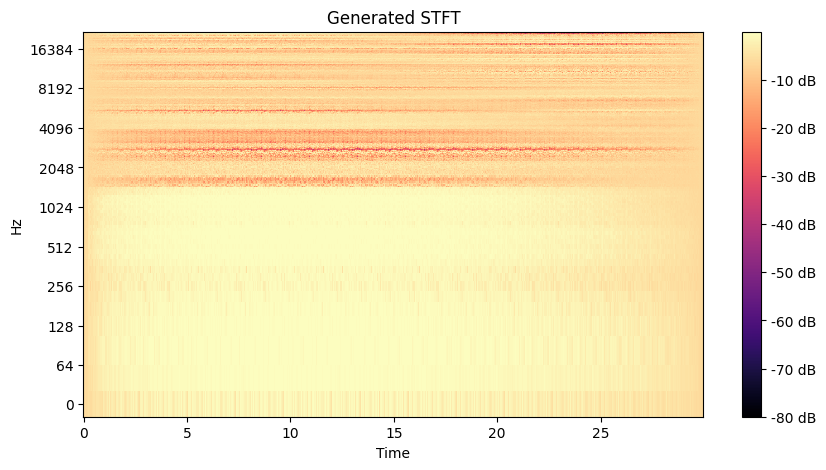

In [75]:
import librosa
import librosa.display
import soundfile as sf

sr = 44100

# Generar un ejemplo a partir del ruido
noise = torch.randn(1, noise_dim, 1, 1)
generated_stft = generator(noise).detach().numpy()
generated_stft = generated_stft.squeeze()

# Graficar el STFT generado
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(generated_stft, ref=np.max), sr=sr, hop_length=hop_length, y_axis='log', x_axis='time')
plt.title('Generated STFT')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Convertir el STFT generado de vuelta a una señal de audio
def istft(stft_matrix, hop_length, win_length):
    return librosa.istft(stft_matrix, hop_length=hop_length, win_length=win_length)

generated_audio = istft(generated_stft, hop_length=hop_length, win_length=hop_length)

# Guardar el audio generado
# librosa.output.write_wav('generated_audio.wav', generated_audio, sr=22050)
sf.write('generated_audio.wav', generated_audio, samplerate=sr)


# Reproducir el audio generado
import IPython.display as ipd
ipd.Audio(generated_audio, rate=sr)

In [76]:
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

# Parámetros de STFT y audio original
n_fft = 1024
hop_length = 512
sr = 44100  # Frecuencia de muestreo

# Suponiendo que generated_stft es la matriz STFT generada por el modelo
# generated_stft = generated_stft.squeeze()  # Eliminar dimensiones adicionales si las hay

# Convertir STFT a audio usando librosa
generated_audio = librosa.istft(generated_stft, hop_length=hop_length, win_length=n_fft)

# Guardar el audio generado
# librosa.output.write_wav('generated_audio.wav', generated_audio, sr=sr)
sf.write('generated_audio.wav', generated_audio, samplerate=sr)

# Reproducir el audio generado
ipd.Audio('generated_audio.wav')